In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
import os
from collections import defaultdict, Counter

In [5]:
import math

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

## Constants

In [7]:
data_path = "/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability"

## Get paths of files

In [8]:
base_file_dict = defaultdict(list)
tax_registry_a_1_file_dict = defaultdict(list)
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith('parquet'):
            file_type = 'train' if 'train' in file_path else 'test'
            if 'base' in file_path:
                base_file_dict[file_type].append(file_path)
            if 'tax_registry_a_1' in file_path:
                tax_registry_a_1_file_dict[file_type].append(file_path)

In [9]:
tax_registry_a_1_file_dict.get("train")

['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_tax_registry_a_1.parquet']

## Functions

In [10]:
def get_column_description(feature_def_df, column_name):
    return feature_def_df[feature_def_df.Variable == column_name]['Description'].iloc[0]

In [11]:
def plot_scatterplot(df, x_col_name, y_col_name, show_x_y_line=False):
    assert x_col_name in df.columns, f"Ensure that {x_col_name} is in the df"
    assert y_col_name in df.columns, f"Ensure that {y_col_name} is in the df"
    
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x=df[x_col_name], y=df[y_col_name], ax=axs)
    
    if show_x_y_line:
        df[x_col_name] = df[x_col_name].replace([np.inf, -np.inf], np.nan)
        df[y_col_name] = df[y_col_name].replace([np.inf, -np.inf], np.nan)
        not_null_x_filter = ~df[x_col_name].isnull()
        not_null_y_filter = ~df[y_col_name].isnull()
        not_null_filter = not_null_x_filter & not_null_y_filter
        filtered_df = df[not_null_filter]
        x_values_series = filtered_df[x_col_name]
        y_values_series = filtered_df[y_col_name]
        x0, x1 = min(x_values_series), max(x_values_series)
        y0, y1 = min(y_values_series), max(y_values_series)
        #line_values = [i for i in np.arange(min(x0, y0), max(x1, y1), 0.1)]
        lims = [min(x0, y0), max(x1, y1)]
        print(f"lims: {lims}")
        plt.plot(lims, lims)
    return fig

In [12]:
def get_percent_of_column(df, groupby_column, target_column):
    target_df = df.groupby(by=[groupby_column]).agg({target_column:"sum"}).reset_index()
    all_rows_df = df.groupby(by=[groupby_column]).size().reset_index().rename({0:"total_rows"}, axis=1)
    merged_df = target_df.merge(all_rows_df, left_on=[groupby_column], right_on=[groupby_column], how="left")
    merged_df["percentage_default"] = 100*merged_df["target"]/merged_df["total_rows"]
    merged_df[groupby_column] = merged_df[groupby_column].astype(str)
    return merged_df

In [13]:
def plot_barplot(df, percent_column, category_column):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(ax=ax, data=df, y=category_column, x=percent_column, order=df.sort_values(by=[percent_column], ascending=False)[category_column].values)
    return fig

In [14]:
def get_relevant_indices(series):
    percentile_25 = series.quantile(0.25)
    percentile_75 = series.quantile(0.75)
    iqr = percentile_75-percentile_25
    upper_limit = percentile_75 + 1.5*iqr
    lower_limit = percentile_25 - 1.5*iqr

    keep_indices = series[(series>=lower_limit) & (series<=upper_limit)].index
    return keep_indices 

## Read datasets

In [15]:
feature_df = pd.read_csv(f"{data_path}/feature_definitions.csv")
print(f"Shape of feature_df: {feature_df.shape}")

Shape of feature_df: (465, 2)


In [16]:
train_base_df = pd.concat([pd.read_parquet(file_path) for file_path in base_file_dict['train']], axis=0)
print(f"Shape of train_base_df: {train_base_df.shape}")

Shape of train_base_df: (1526659, 5)


## Properties: depth=1, internal data source

In [17]:
tax_registry_a_1_df = pd.concat([pd.read_parquet(file_path) for file_path in tax_registry_a_1_file_dict['train']], axis=0)
print(f"Shape of tax_registry_a_1_df: {tax_registry_a_1_df.shape}")

Shape of tax_registry_a_1_df: (3275770, 5)


In [18]:
tax_registry_a_1_df.columns.unique()

Index(['case_id', 'amount_4527230A', 'name_4527232M', 'num_group1',
       'recorddate_4527225D'],
      dtype='object')

In [19]:
train_base_df["date_decision"] = pd.to_datetime(train_base_df["date_decision"])

tax_registry_a_1_df["recorddate_4527225D"] = pd.to_datetime(tax_registry_a_1_df["recorddate_4527225D"])

## This means that there are multiple rows for each case_id indexed by num_group1

In [20]:
unique_num_group_case_id_df = tax_registry_a_1_df.groupby(by=["case_id"]).agg({"num_group1": "nunique"}).reset_index().rename({"num_group1": "generated_count_of_tax_information_by_provider_a"}, axis=1)

In [21]:
unique_num_group_case_id_df[unique_num_group_case_id_df.generated_count_of_tax_information_by_provider_a>10].sort_values(by=["generated_count_of_tax_information_by_provider_a"]).head(5)

,case_id,generated_count_of_tax_information_by_provider_a
371900,1763377,11
220448,1547262,11
102269,853226,11
322970,1694044,11
322959,1694029,11


In [22]:
tax_registry_a_1_df[tax_registry_a_1_df.case_id == 1694029].sort_values(by=["num_group1"]).head()

,case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D
2268531,1694029,5918.0,ef9f9354,0,2019-12-31
2268529,1694029,3276.8,ef9f9354,1,2019-12-31
2268524,1694029,666.2,ef9f9354,2,2019-12-31
2268527,1694029,2622.8,ef9f9354,3,2019-12-31
2268521,1694029,604.0,ef9f9354,4,2019-12-31


<Axes: ylabel='generated_count_of_tax_information_by_provider_a'>

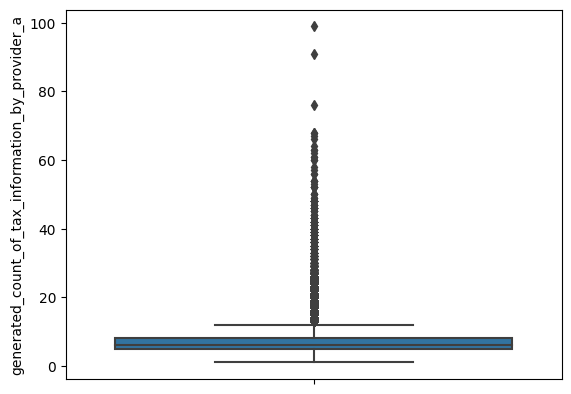

In [23]:
sns.boxplot(data=unique_num_group_case_id_df, y="generated_count_of_tax_information_by_provider_a")

## Number of tax related records provided for case_ids vary from 1 to 99

### 1. recorddate_4527225D

In [24]:
get_column_description(feature_df, "recorddate_4527225D")

'Date of tax deduction record.'

In [25]:
tax_registry_a_1_df.recorddate_4527225D.isnull().value_counts()

recorddate_4527225D
False    3275770
Name: count, dtype: int64

In [26]:
## Check across how unique dates are tax deduction records for a given case_id
statistics_recorddate_4527225D_for_case_id_df = tax_registry_a_1_df.groupby(by=["case_id"]).agg({"recorddate_4527225D": ["nunique", "max"]}).reset_index()
statistics_recorddate_4527225D_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_recorddate_4527225D_for_case_id_df.columns]

In [27]:
statistics_recorddate_4527225D_for_case_id_df.head(2)

,case_id,generated_recorddate_4527225D_nunique,generated_recorddate_4527225D_max
0,28631,1,2019-09-13
1,28632,1,2019-09-13


In [28]:
statistics_recorddate_4527225D_for_case_id_df["generated_recorddate_4527225D_nunique"].value_counts()

generated_recorddate_4527225D_nunique
1    457934
Name: count, dtype: int64

## A case_id is associated with only 1 recorddate_4527225D

## Is this the date on which tax deduction record was provided by the registry to homecredit instead of the date of tx deduction??

In [29]:
print(f"Min recorddate_4527225D: {tax_registry_a_1_df.recorddate_4527225D.min()}")
print(f"Max recorddate_4527225D: {tax_registry_a_1_df.recorddate_4527225D.max()}")

Min recorddate_4527225D: 2019-09-13 00:00:00
Max recorddate_4527225D: 2020-10-19 00:00:00


## This record information is obtained across an year...

In [31]:
merged_train_base_statistics_recorddate_4527225D_for_case_id_df = train_base_df.merge(statistics_recorddate_4527225D_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_recorddate_4527225D_for_case_id_df: {merged_train_base_statistics_recorddate_4527225D_for_case_id_df.shape}")

Shape of merged_train_base_statistics_recorddate_4527225D_for_case_id_df: (1526659, 7)


In [32]:
merged_train_base_statistics_recorddate_4527225D_for_case_id_df["day_gap_between_recorddate_4527225D_and_date_decision"] = (merged_train_base_statistics_recorddate_4527225D_for_case_id_df["generated_recorddate_4527225D_max"]-merged_train_base_statistics_recorddate_4527225D_for_case_id_df["date_decision"]).dt.days

In [33]:
merged_train_base_statistics_recorddate_4527225D_for_case_id_df[~merged_train_base_statistics_recorddate_4527225D_for_case_id_df.generated_recorddate_4527225D_nunique.isnull()]["day_gap_between_recorddate_4527225D_and_date_decision"].value_counts()

day_gap_between_recorddate_4527225D_and_date_decision
14.0    447430
13.0      5781
12.0      1802
11.0      1030
10.0       707
9.0        503
8.0        398
7.0        275
6.0          5
4.0          1
3.0          1
5.0          1
Name: count, dtype: int64

## Provider A provides tax documents within 2 weeks of loan approval date (date_decision)

### 2. name_4527232M

In [34]:
get_column_description(feature_df, "name_4527232M")

'Name of employer.'

In [40]:
statistics_name_4527232M_for_case_id_df = tax_registry_a_1_df.groupby(by=["case_id"]).agg(generated_name_4527232M_nunique=pd.NamedAgg(column="name_4527232M", aggfunc="nunique"), generated_name_4527232M_mode=pd.NamedAgg(column="name_4527232M", aggfunc=lambda x:x.value_counts().index[0]))

In [43]:
statistics_name_4527232M_for_case_id_df

,generated_name_4527232M_nunique,generated_name_4527232M_mode
case_id,,
28631,1,f980a1ea
28632,1,5f9b74f5
28633,1,5e180ef0
28635,1,52c166dc
28636,1,5574ff1b
...,...,...
2697303,1,5e180ef0
2700297,1,5e180ef0
2701074,1,35d8278b


### 3. amount_4527230A

In [44]:
get_column_description(feature_df, "amount_4527230A")

'Tax deductions amount tracked by the government registry.'

In [45]:
statistics_amount_4527230A_df = tax_registry_a_1_df.groupby(by=["case_id"]).agg({"amount_4527230A": ["max", "min", "mean"]}).reset_index()
statistics_amount_4527230A_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_amount_4527230A_df.columns]

In [49]:
statistics_amount_4527230A_df.shape

(457934, 4)

In [48]:
statistics_amount_4527230A_df[statistics_amount_4527230A_df.case_id.isin([49435, 49490, 49526])]

,case_id,generated_amount_4527230A_max,generated_amount_4527230A_min,generated_amount_4527230A_mean
12198,49435,850.0,850.0,850.000000
12232,49490,1337.6,1067.4,1150.966733
12254,49526,3776.2,3685.8,3731.000000


In [50]:
statistics_amount_4527230A_df.sort_values(by=["case_id"]).head()

,case_id,generated_amount_4527230A_max,generated_amount_4527230A_min,generated_amount_4527230A_mean
0,28631,3616.4001,711.0000,2218.350025
1,28632,2564.0000,400.0000,1405.180010
2,28633,151.6000,151.6000,151.600000
3,28635,5637.8003,5461.8003,5549.800300
4,28636,2628.6000,850.0000,1773.942871
